<a href="https://colab.research.google.com/github/davidesqalv/EMNIST-CNN-Kernel-training-test/blob/main/tarea3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#setup

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from PIL import Image
import PIL.ImageOps 

import numpy as np
np.set_printoptions(precision=3, suppress=True)

from scipy import io as spio

import matplotlib.pyplot as plt
import pandas as pd
import random
import copy

from sklearn.model_selection import train_test_split
from sklearn import preprocessing, metrics
from sklearn.metrics import confusion_matrix
from mpl_toolkits.mplot3d import Axes3D

from keras.models import Sequential
from tensorflow.keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
import sklearn.metrics as metrics

from mlxtend.plotting import plot_confusion_matrix


#impresion de mapas de convolucion
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from numpy import expand_dims
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#Config

In [ ]:
def rotate(image):
    image = image.reshape([HEIGHT, WIDTH])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

In [ ]:
train = pd.read_csv('/content/drive/My Drive/IA_TEC/tarea3/emnist-balanced-train.csv',delimiter = ',')

test = pd.read_csv('/content/drive/My Drive/IA_TEC/tarea3/emnist-balanced-test.csv',delimiter = ',')

mapp = pd.read_csv("/content/drive/My Drive/IA_TEC/tarea3/emnist-balanced-mapping.txt", delimiter = ' ', \
                   index_col=0, header=None, squeeze=True)

print("Train: %s, Test: %s, Map: %s" %(train.shape, test.shape, mapp.shape))

HEIGHT = 28
WIDTH = 28

Train: (112799, 785), Test: (18799, 785), Map: (47,)


#Dataset sampling

In [ ]:
print(f"Train: {len(train)}")

train_sample=train.groupby(train.iloc[:,0], as_index = False, group_keys=False).apply(lambda s: s.sample(100))


train.drop(train_sample.index)

test_sample=train.groupby(train.iloc[:,0], as_index = False, group_keys=False).apply(lambda s: s.sample(60))

print(f"Train: {len(train)}")

Train: 112799
Train: 112799


In [ ]:
print("Train: %s, Test: %s, Map: %s" %(np.array(train_sample).shape, np.array(test_sample).shape, mapp.shape))

Train: (4700, 785), Test: (2820, 785), Map: (47,)


In [ ]:
# Separar los datos (x) de la etiqueta (y)
train_x = train_sample.iloc[:,1:]
train_y = train_sample.iloc[:,0]

test_x = test_sample.iloc[:,1:]
test_y = test_sample.iloc[:,0]

In [ ]:
print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)

# Flip and rotate image
train_x = np.asarray(train_x)
train_x = np.apply_along_axis(rotate, 1, train_x)
print ("train_x:",train_x.shape)

test_x = np.asarray(test_x)
test_x = np.apply_along_axis(rotate, 1, test_x)
print ("test_x:",test_x.shape)

print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)


(4700, 784) (4700,) (2820, 784) (2820,)
train_x: (4700, 28, 28)
test_x: (2820, 28, 28)
(4700, 28, 28) (4700,) (2820, 28, 28) (2820,)


In [ ]:
train_x = train_x.astype('float32')
test_x = test_x.astype('float32')
train_x, test_x = train_x / 255, test_x / 255



In [ ]:
print(train_y.shape)
print(test_y.shape)

(4700,)
(2820,)


##Images

In [ ]:
print(len(train_y))
print(np.array(train_y))

carac = int(len(train_y)/100)

train_y_array = np.array(train_y)


for j in range(carac):
  print(f'indice: {j}')
  carac_index = j*100;

  for i in range(9):
    plt.subplot(330 + (i+101))
    plt.imshow(train_x[carac_index+i], cmap=plt.get_cmap('gray'))
    plt.title(chr(mapp[train_y_array[carac_index+i]]))
  
  plt.show()

In [ ]:
train_y = train_y_array

In [ ]:
clases = len(set(train_y))

print(f'clases {clases}')

train_y = tf.keras.utils.to_categorical(train_y)
 
test_y = tf.keras.utils.to_categorical(test_y)

train_x = np.asarray(train_x).reshape(
    -1, HEIGHT, WIDTH, 1
)

test_x = np.asarray(test_x).reshape(
    -1, HEIGHT, WIDTH, 1
)

clases 47


In [ ]:
print(train_x.shape)
# print(val_x.shape)
print(train_y.shape)
# print(val_y.shape)

(4700, 28, 28, 1)
(4700, 47)


#0: 128 + 64 kernels


In [ ]:
model = tf.keras.models.Sequential([

    # Convolutional layer. Learn 32 filters using a 3x3 kernel
    tf.keras.layers.Conv2D(
        128, (5, 5), activation="relu", input_shape=(HEIGHT, WIDTH, 1), padding = 'same'
    ),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding = 'same'),
    tf.keras.layers.Conv2D(
        64, (3, 3), activation="relu", padding = 'same'
    ),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding = 'same'),

    # Flatten units
    tf.keras.layers.Flatten(),

    # Add a hidden layer with dropout
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),

    # Add an output layer with output units for all 10 digits
    tf.keras.layers.Dense(clases, activation="softmax")
])

model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 14, 14, 64)        73792     
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_112 (Dense)            (None, 128)               401536    
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)             

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(train_x, train_y, epochs=10, verbose=1, 
                    validation_data=(test_x, test_y))
# model.evaluate(test_x,  test_y, verbose=2)

Epoch 1/10
92/92 [==============================] - 9s 95ms/step - loss: 3.7002 - accuracy: 0.0642 - val_loss: 2.2445 - val_accuracy: 0.4429
Epoch 2/10
92/92 [==============================] - 9s 93ms/step - loss: 2.3934 - accuracy: 0.3269 - val_loss: 1.3159 - val_accuracy: 0.6440
Epoch 3/10
92/92 [==============================] - 8s 92ms/step - loss: 1.7873 - accuracy: 0.4841 - val_loss: 1.0333 - val_accuracy: 0.6996
Epoch 4/10
92/92 [==============================] - 8s 92ms/step - loss: 1.3475 - accuracy: 0.5951 - val_loss: 0.9459 - val_accuracy: 0.7174
Epoch 5/10
92/92 [==============================] - 9s 93ms/step - loss: 1.1581 - accuracy: 0.6520 - val_loss: 0.8505 - val_accuracy: 0.7429
Epoch 6/10
92/92 [==============================] - 9s 93ms/step - loss: 1.0450 - accuracy: 0.6745 - val_loss: 0.7741 - val_accuracy: 0.7535
Epoch 7/10
92/92 [==============================] - 9s 93ms/step - loss: 0.9439 - accuracy: 0.7085 - val_loss: 0.7314 - val_accuracy: 0.7635
Epoch 8/10
92

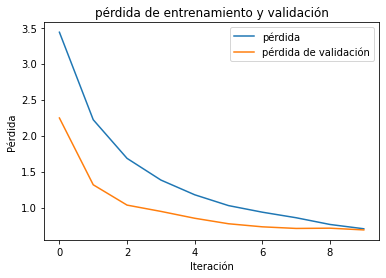

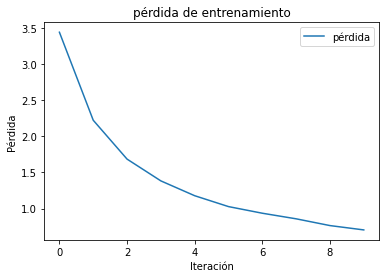

In [ ]:
#se grafica la progresion de la presicion y la perdida
plt.plot(history.history['loss'], label="pérdida")
plt.plot(history.history['val_loss'], label="pérdida de validación")
plt.title('pérdida de entrenamiento y validación')
plt.xlabel('Iteración')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label="pérdida")
plt.title('pérdida de entrenamiento')
plt.xlabel('Iteración')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

##Layer printing

In [ ]:
def imprimir_filtros(model):
  for i in range(len(model.layers)):
      layer = model.layers[i]
      if 'conv' not in layer.name:
          continue    
      print(i , layer.name , layer.output.shape)
    
  model_1 = Model(inputs=model.inputs , outputs=model.layers[0].output)

  print(np.array(train_x).shape)

  features = model_1.predict(train_x)

  print(f'{np.array(features).shape}')

  for letra in range(clases):

    fig = plt.figure(figsize=(20,15))

    indice_letra = letra*100

    for i in range(1,features.shape[3]+1):

        plt.subplot(8,8,i)
        plt.imshow(features[indice_letra,:,:,i-1] , cmap='gray')
        
    plt.show()

0 conv2d_70 (None, 28, 28, 8)
(2937, 28, 28, 1)
(2937, 28, 28, 8)


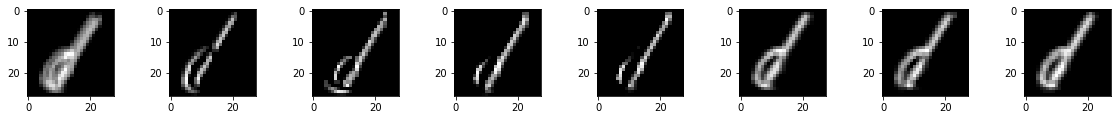

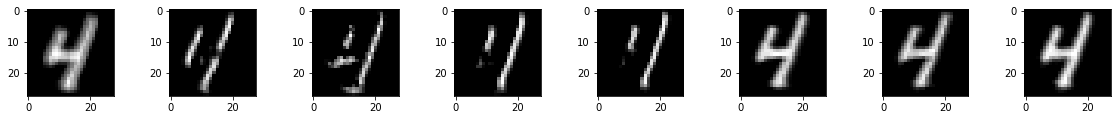

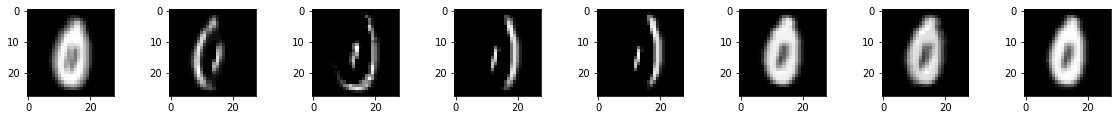

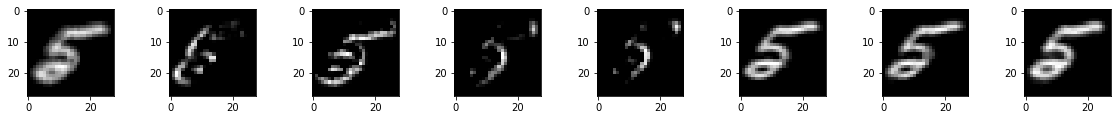

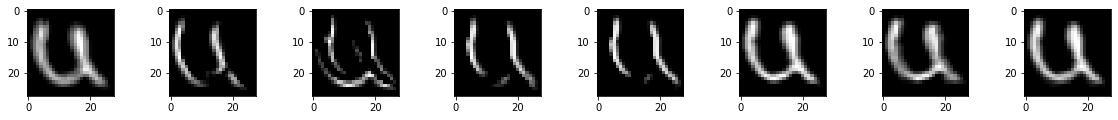

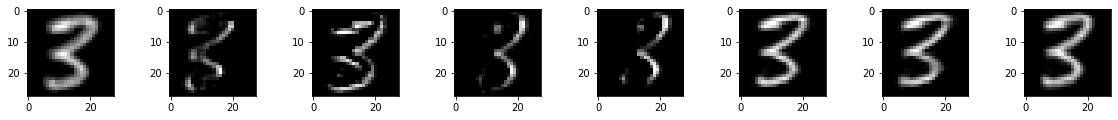

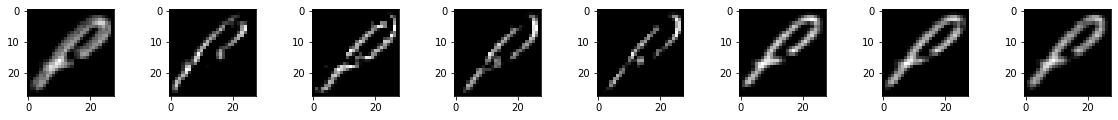

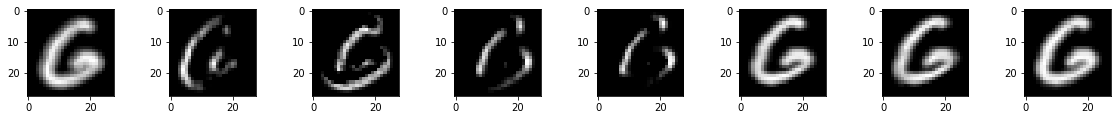

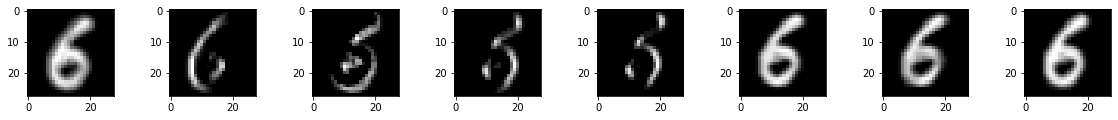

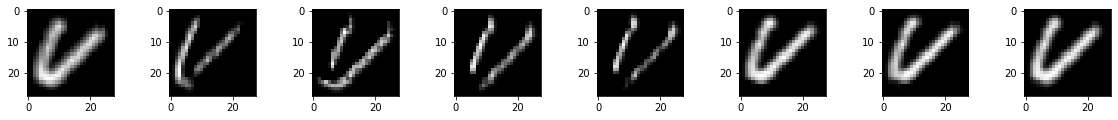

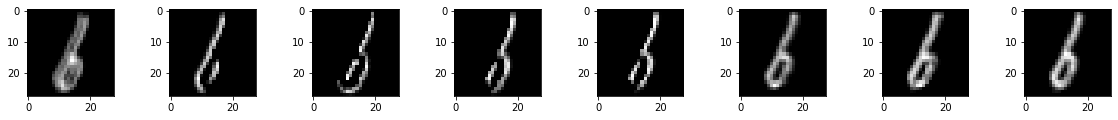

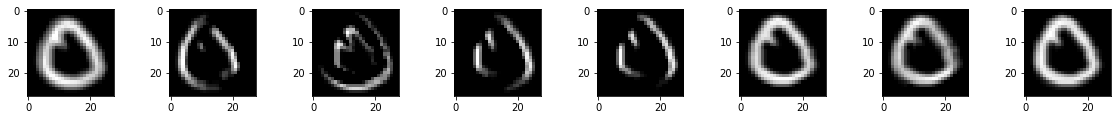

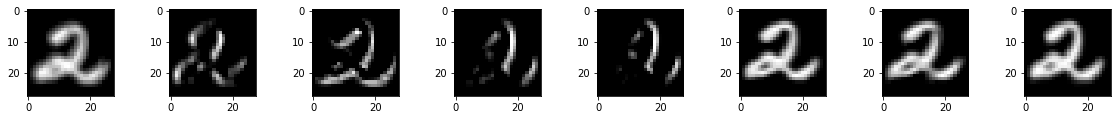

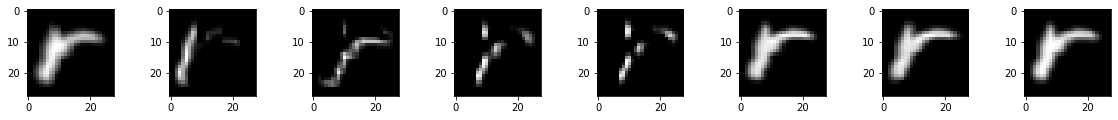

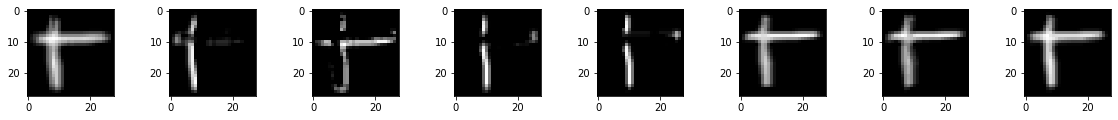

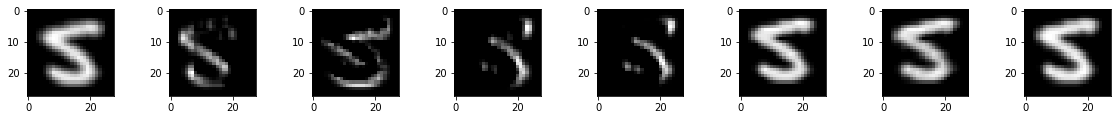

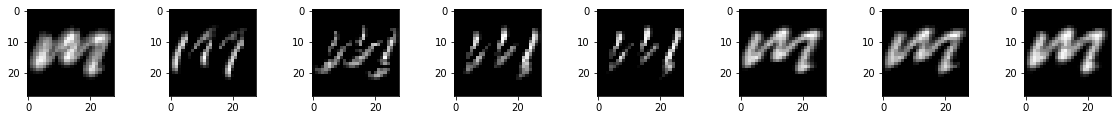

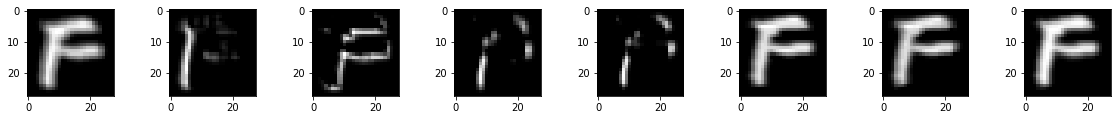

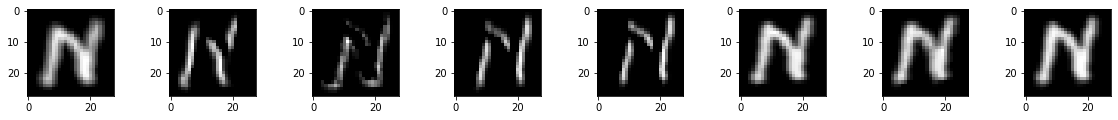

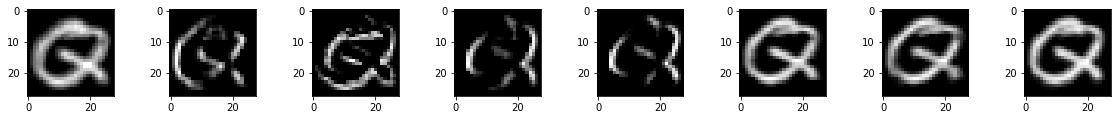

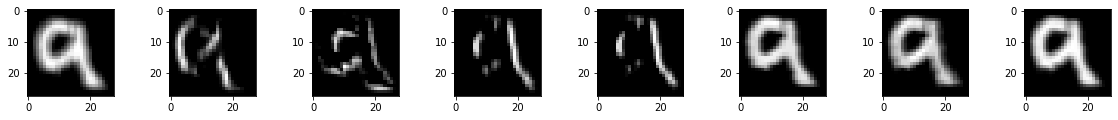

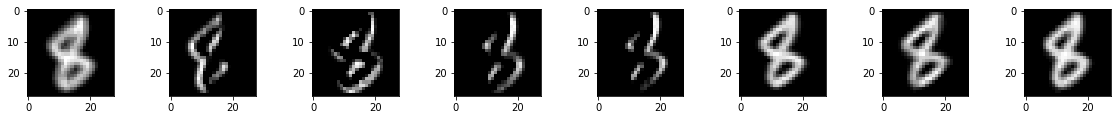

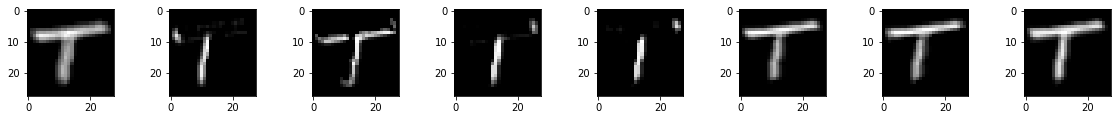

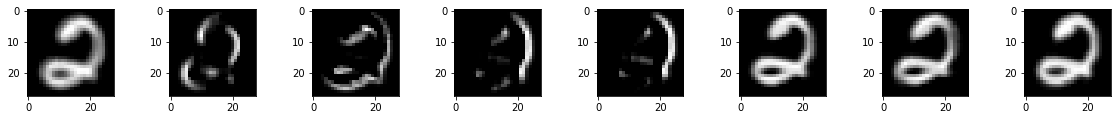

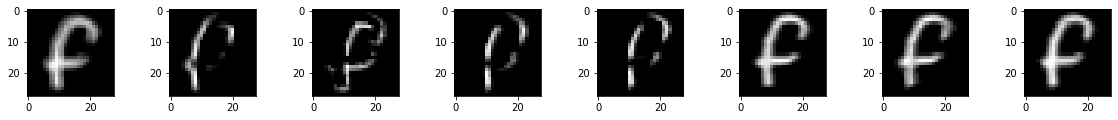

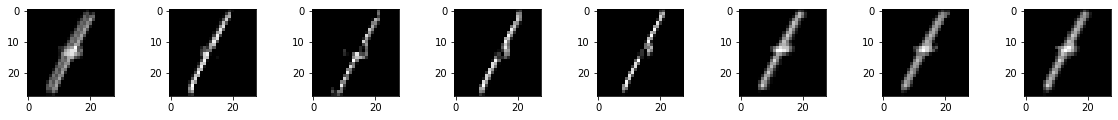

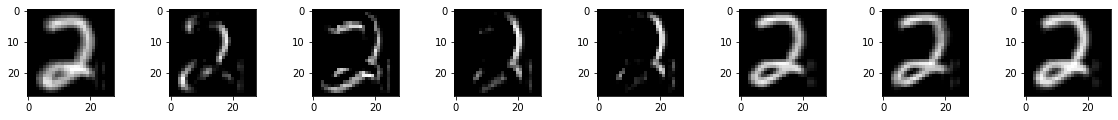

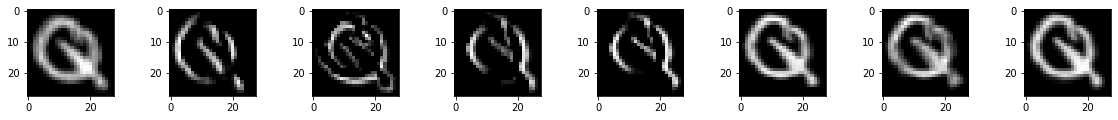

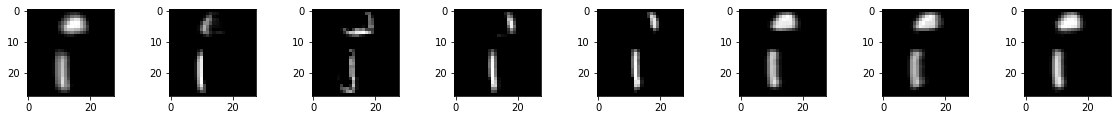

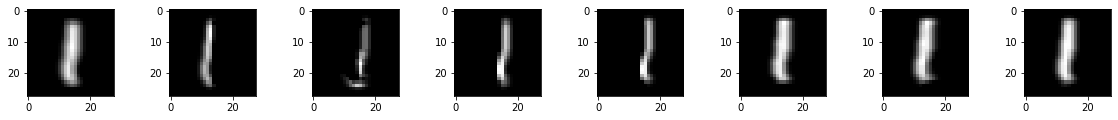

IndexError: ignored

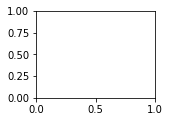

In [ ]:
imprimir_filtros(model)

#1: 8 kernels


In [ ]:
model = tf.keras.models.Sequential([

    # Convolutional layer. Learn 32 filters using a 3x3 kernel
    tf.keras.layers.Conv2D(
        8, (5, 5), activation="relu", input_shape=(HEIGHT, WIDTH, 1), padding = 'same'
    ),
    tf.keras.layers.MaxPooling2D(pool_size=(4, 4), strides=(2,2), padding = 'same'),

    # Flatten units
    tf.keras.layers.Flatten(),

    # Add a hidden layer with dropout
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),

    # Add an output layer with output units for all 10 digits
    tf.keras.layers.Dense(clases, activation="softmax")
])

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 28, 28, 8)         208       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 8)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 1568)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               200832    
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 47)                6063      
Total params: 207,103
Trainable params: 207,103
Non-trainable params: 0
_______________________________________________

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(train_x, train_y, epochs=10, verbose=1, 
                    validation_data=(test_x, test_y))
# model.evaluate(test_x,  test_y, verbose=2)

Epoch 1/10
147/147 [==============================] - 5s 28ms/step - loss: 3.5669 - accuracy: 0.0935 - val_loss: 2.2465 - val_accuracy: 0.4387
Epoch 2/10
147/147 [==============================] - 4s 27ms/step - loss: 2.3860 - accuracy: 0.3363 - val_loss: 1.5302 - val_accuracy: 0.5872
Epoch 3/10
147/147 [==============================] - 4s 27ms/step - loss: 1.7856 - accuracy: 0.4737 - val_loss: 1.2047 - val_accuracy: 0.6543
Epoch 4/10
147/147 [==============================] - 4s 26ms/step - loss: 1.4896 - accuracy: 0.5433 - val_loss: 1.0888 - val_accuracy: 0.6798
Epoch 5/10
147/147 [==============================] - 4s 26ms/step - loss: 1.3230 - accuracy: 0.5968 - val_loss: 0.9560 - val_accuracy: 0.7092
Epoch 6/10
147/147 [==============================] - 4s 27ms/step - loss: 1.1680 - accuracy: 0.6389 - val_loss: 0.8295 - val_accuracy: 0.7447
Epoch 7/10
147/147 [==============================] - 4s 26ms/step - loss: 1.0689 - accuracy: 0.6460 - val_loss: 0.8037 - val_accuracy: 0.7511

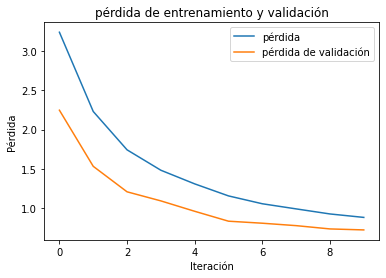

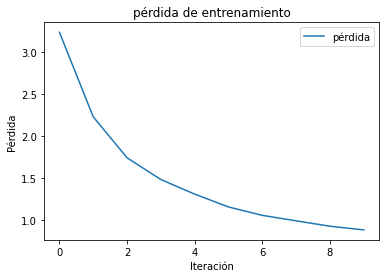

In [ ]:
#se grafica la progresion de la presicion y la perdida
plt.plot(history.history['loss'], label="pérdida")
plt.plot(history.history['val_loss'], label="pérdida de validación")
plt.title('pérdida de entrenamiento y validación')
plt.xlabel('Iteración')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label="pérdida")
plt.title('pérdida de entrenamiento')
plt.xlabel('Iteración')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

##Layer printing

In [ ]:
def imprimir_filtros(model):
  for i in range(len(model.layers)):
      layer = model.layers[i]
      if 'conv' not in layer.name:
          continue    
      print(i , layer.name , layer.output.shape)
    
  model_1 = Model(inputs=model.inputs , outputs=model.layers[0].output)

  print(np.array(train_x).shape)

  features = model_1.predict(train_x)

  print(f'{np.array(features).shape}')

  for letra in range(clases):

    fig = plt.figure(figsize=(20,15))

    indice_letra = letra*100

    for i in range(1,features.shape[3]+1):

        plt.subplot(8,8,i)
        plt.imshow(features[indice_letra,:,:,i-1] , cmap='gray')
        
    plt.show()

0 conv2d_13 (None, 28, 28, 8)
(4700, 28, 28, 1)
(4700, 28, 28, 8)


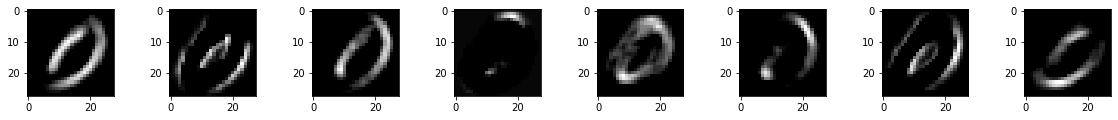

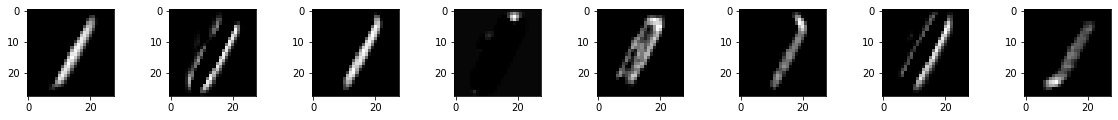

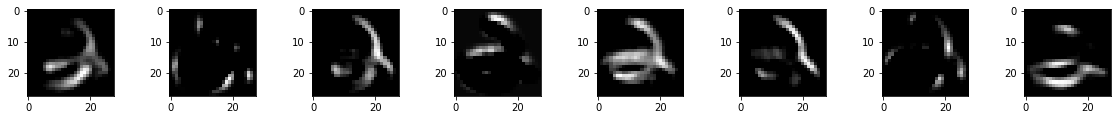

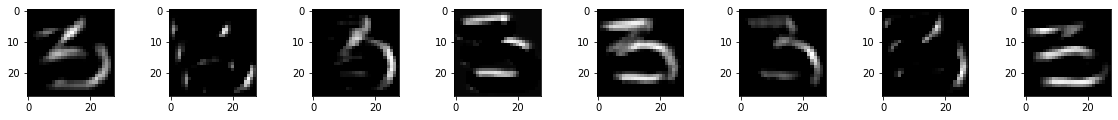

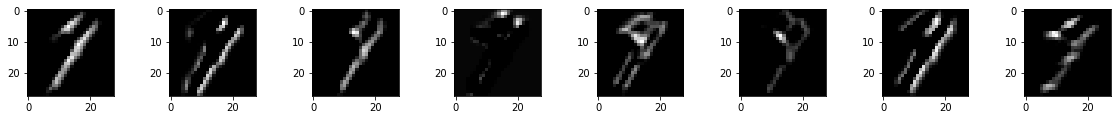

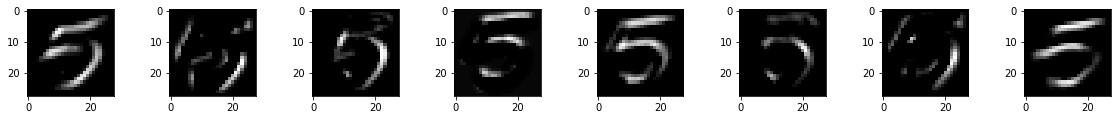

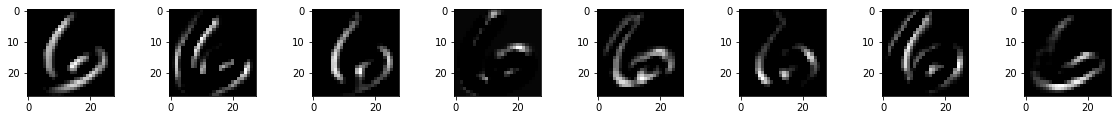

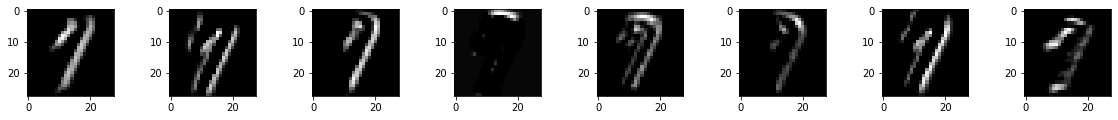

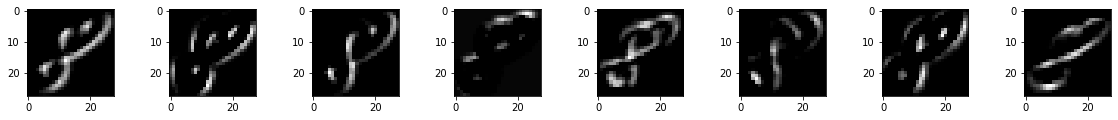

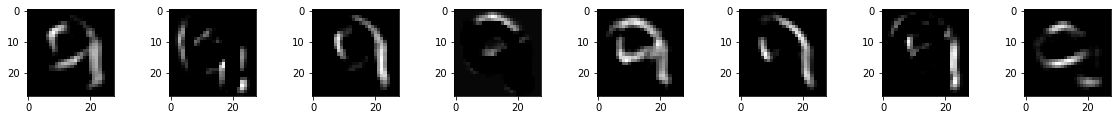

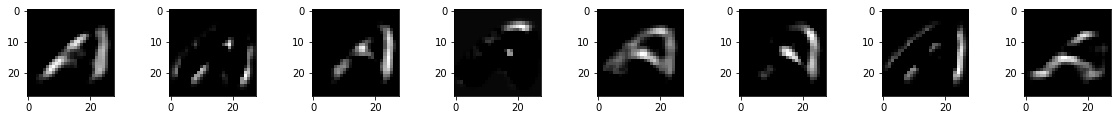

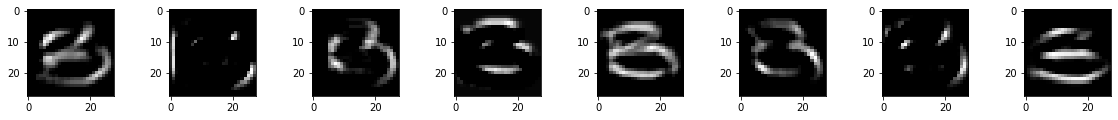

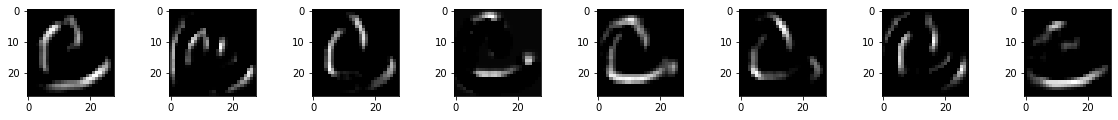

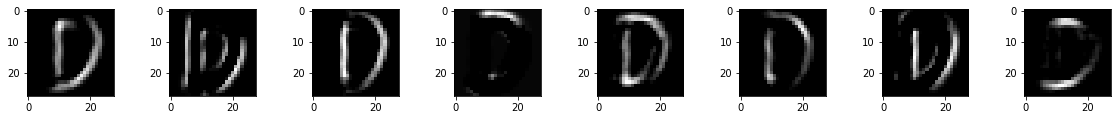

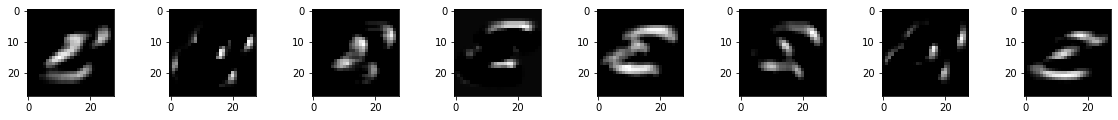

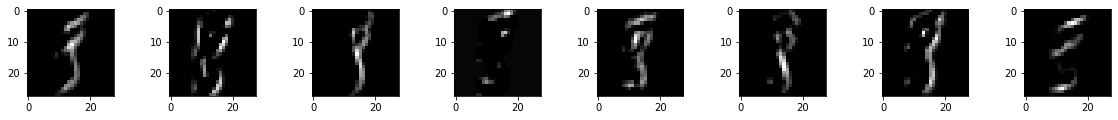

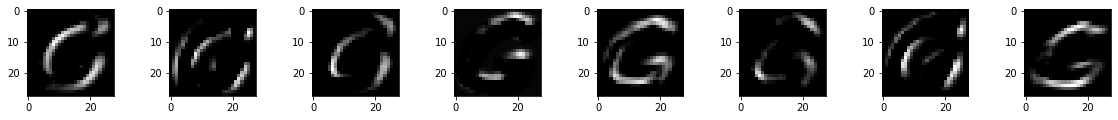

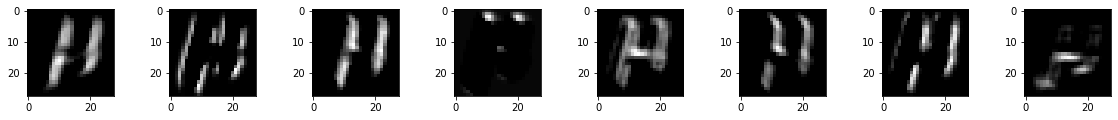

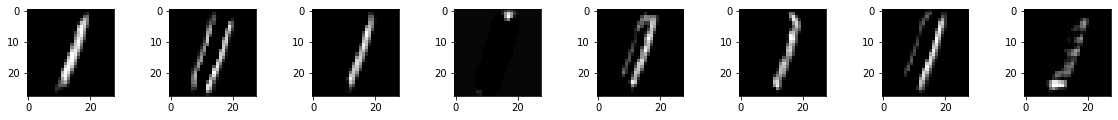

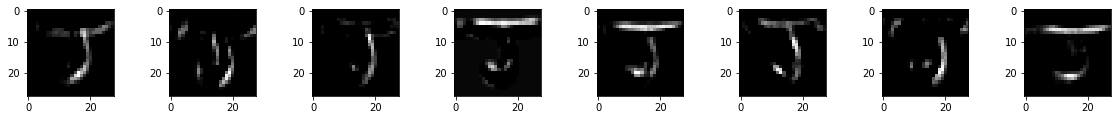

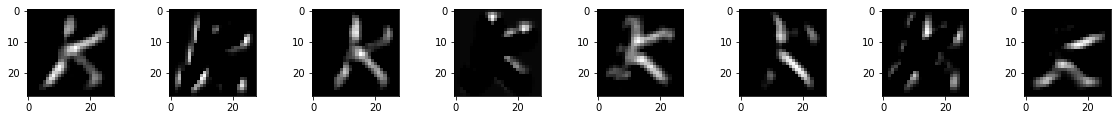

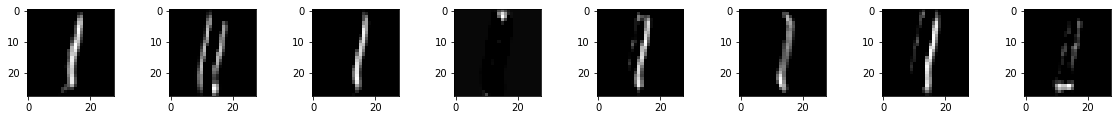

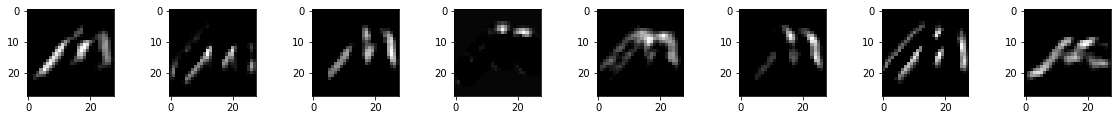

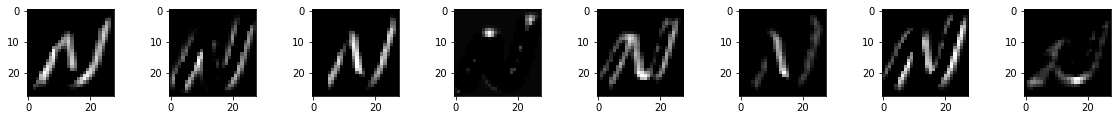

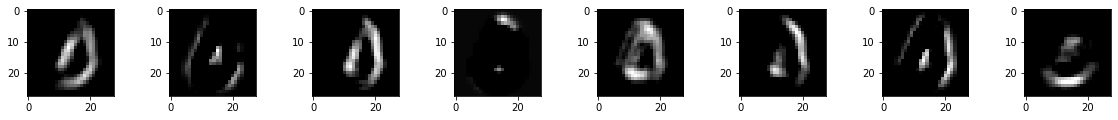

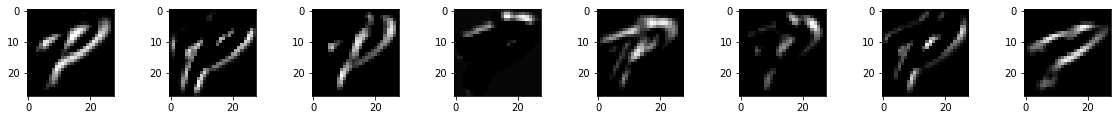

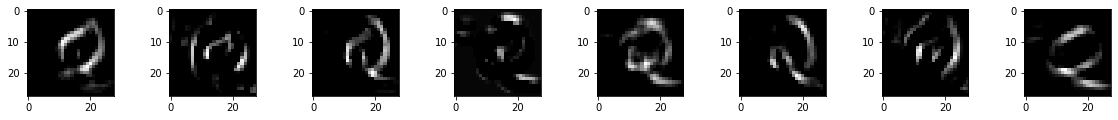

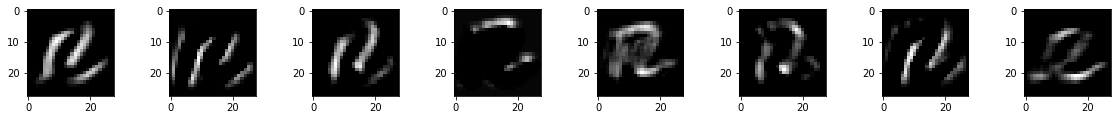

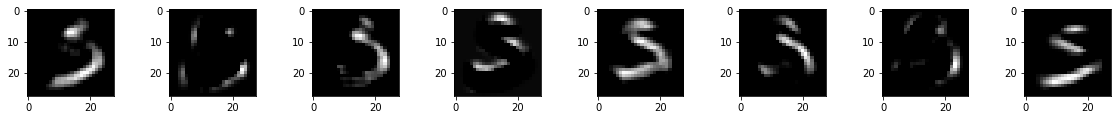

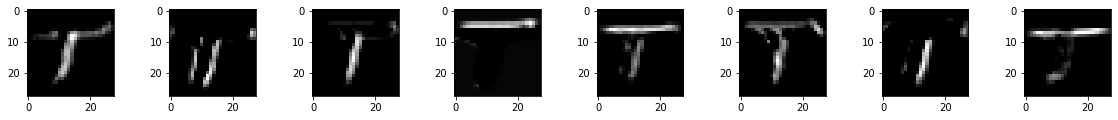

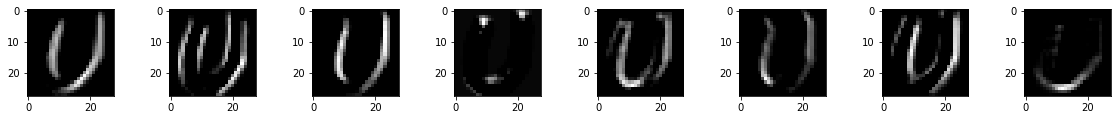

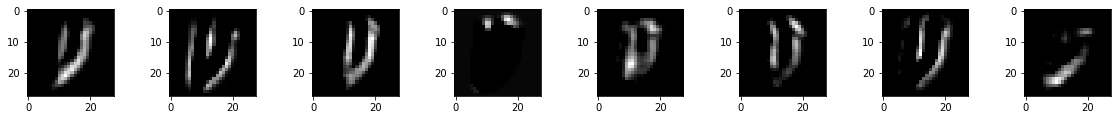

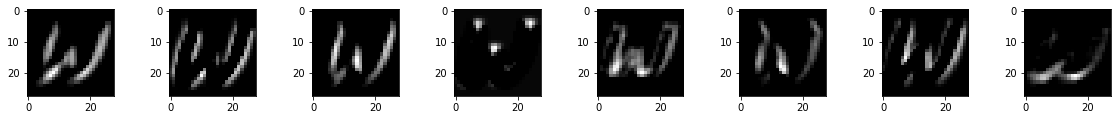

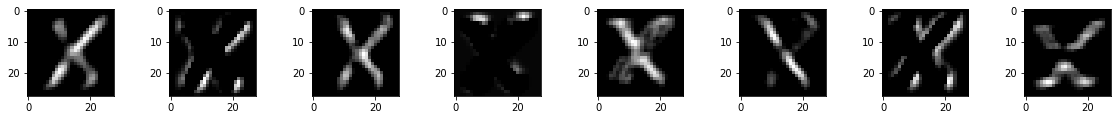

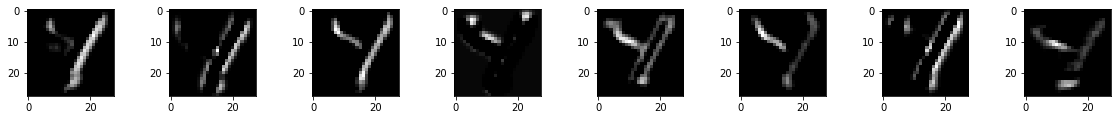

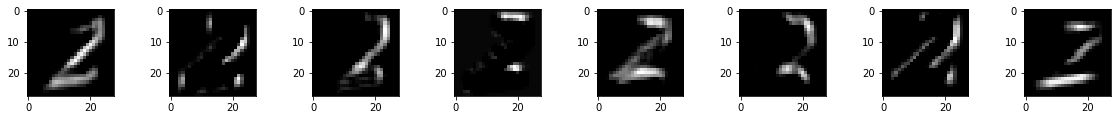

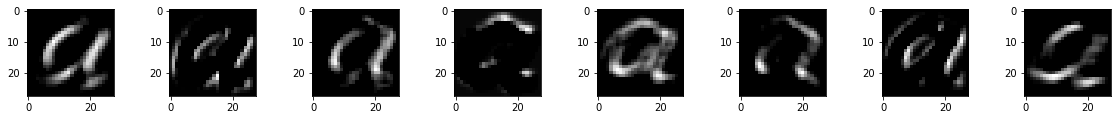

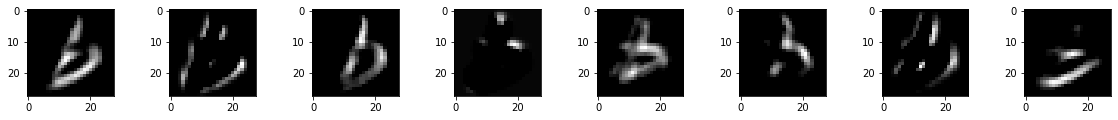

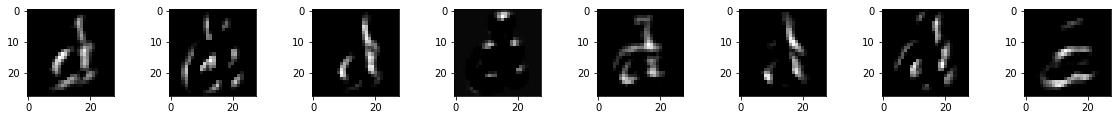

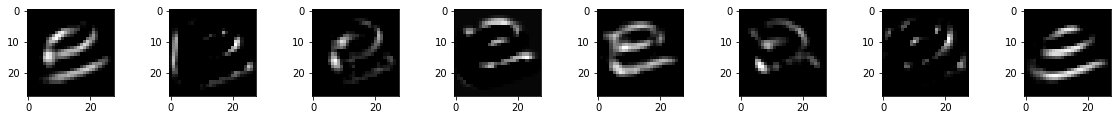

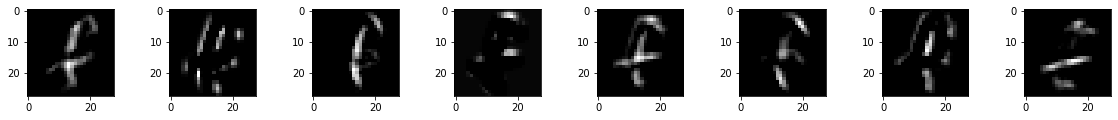

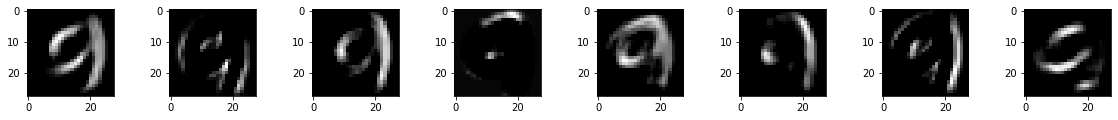

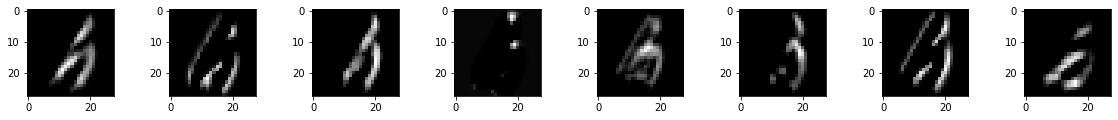

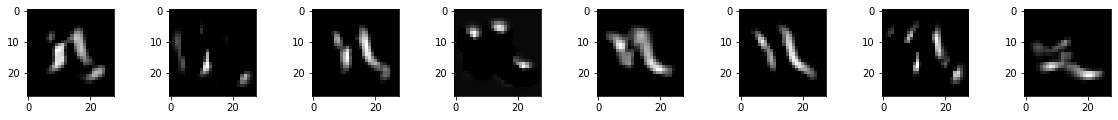

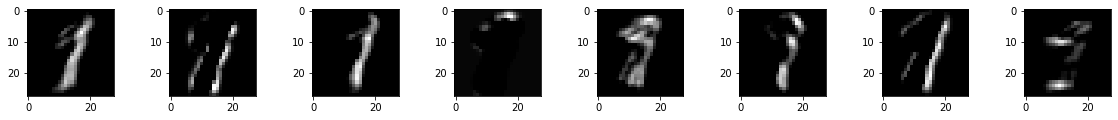

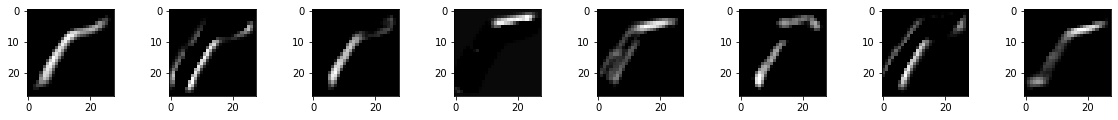

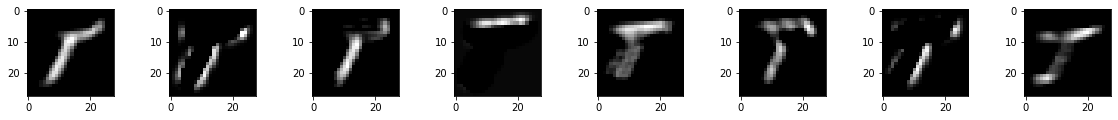

In [ ]:
imprimir_filtros(model)

#2: 16 kernels

In [ ]:
model = tf.keras.models.Sequential([

    # Convolutional layer. Learn 32 filters using a 3x3 kernel
    tf.keras.layers.Conv2D(
        16, (5, 5), activation="relu", input_shape=(HEIGHT, WIDTH, 1), padding = 'same'
    ),
    tf.keras.layers.MaxPooling2D(pool_size=(4, 4), strides=(2,2), padding = 'same'),

    # Flatten units
    tf.keras.layers.Flatten(),

    # Add a hidden layer with dropout
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),

    # Add an output layer with output units for all 10 digits
    tf.keras.layers.Dense(clases, activation="softmax")
])

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               401536    
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 47)                6063      
Total params: 408,015
Trainable params: 408,015
Non-trainable params: 0
_______________________________________________

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(train_x, train_y, epochs=30, verbose=1, 
                    validation_data=(test_x, test_y))
# model.evaluate(test_x,  test_y, verbose=2)

Epoch 1/30
147/147 [==============================] - 5s 29ms/step - loss: 3.5921 - accuracy: 0.0880 - val_loss: 2.2136 - val_accuracy: 0.4777
Epoch 2/30
147/147 [==============================] - 4s 28ms/step - loss: 2.3090 - accuracy: 0.3533 - val_loss: 1.3791 - val_accuracy: 0.6426
Epoch 3/30
147/147 [==============================] - 4s 28ms/step - loss: 1.7645 - accuracy: 0.4735 - val_loss: 1.1194 - val_accuracy: 0.6982
Epoch 4/30
147/147 [==============================] - 4s 28ms/step - loss: 1.5011 - accuracy: 0.5413 - val_loss: 0.9745 - val_accuracy: 0.7060
Epoch 5/30
147/147 [==============================] - 4s 27ms/step - loss: 1.2674 - accuracy: 0.5989 - val_loss: 0.8596 - val_accuracy: 0.7372
Epoch 6/30
147/147 [==============================] - 4s 27ms/step - loss: 1.1927 - accuracy: 0.6390 - val_loss: 0.8106 - val_accuracy: 0.7468
Epoch 7/30
147/147 [==============================] - 4s 27ms/step - loss: 1.0483 - accuracy: 0.6586 - val_loss: 0.7582 - val_accuracy: 0.7681

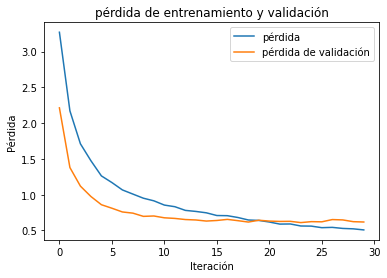

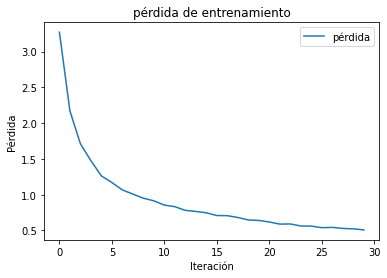

In [ ]:
#se grafica la progresion de la presicion y la perdida
plt.plot(history.history['loss'], label="pérdida")
plt.plot(history.history['val_loss'], label="pérdida de validación")
plt.title('pérdida de entrenamiento y validación')
plt.xlabel('Iteración')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label="pérdida")
plt.title('pérdida de entrenamiento')
plt.xlabel('Iteración')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

#3: 24 kernels

In [ ]:
model = tf.keras.models.Sequential([

    # Convolutional layer. Learn 32 filters using a 3x3 kernel
    tf.keras.layers.Conv2D(
        24, (5, 5), activation="relu", input_shape=(HEIGHT, WIDTH, 1), padding = 'same'
    ),
    tf.keras.layers.MaxPooling2D(pool_size=(4, 4), strides=(2,2), padding = 'same'),

    # Flatten units
    tf.keras.layers.Flatten(),

    # Add a hidden layer with dropout
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),

    # Add an output layer with output units for all 10 digits
    tf.keras.layers.Dense(clases, activation="softmax")
])

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 28, 28, 24)        624       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 24)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 4704)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               602240    
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 47)                6063      
Total params: 608,927
Trainable params: 608,927
Non-trainable params: 0
_______________________________________________

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(train_x, train_y, epochs=10, verbose=1, 
                    validation_data=(test_x, test_y))
# model.evaluate(test_x,  test_y, verbose=2)

Epoch 1/10
147/147 [==============================] - 6s 36ms/step - loss: 3.5661 - accuracy: 0.0891 - val_loss: 2.0494 - val_accuracy: 0.5067
Epoch 2/10
147/147 [==============================] - 5s 34ms/step - loss: 2.2190 - accuracy: 0.3883 - val_loss: 1.3152 - val_accuracy: 0.6514
Epoch 3/10
147/147 [==============================] - 5s 34ms/step - loss: 1.6485 - accuracy: 0.5171 - val_loss: 1.0249 - val_accuracy: 0.7000
Epoch 4/10
147/147 [==============================] - 5s 33ms/step - loss: 1.3885 - accuracy: 0.5705 - val_loss: 0.9235 - val_accuracy: 0.7348
Epoch 5/10
147/147 [==============================] - 5s 33ms/step - loss: 1.2082 - accuracy: 0.6351 - val_loss: 0.8314 - val_accuracy: 0.7433
Epoch 6/10
147/147 [==============================] - 5s 33ms/step - loss: 1.1463 - accuracy: 0.6575 - val_loss: 0.7839 - val_accuracy: 0.7596
Epoch 7/10
147/147 [==============================] - 5s 33ms/step - loss: 1.0289 - accuracy: 0.6604 - val_loss: 0.7498 - val_accuracy: 0.7656

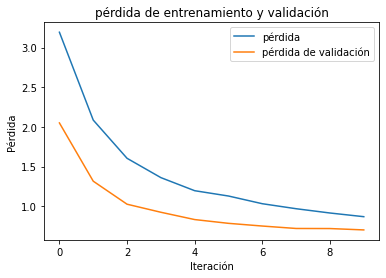

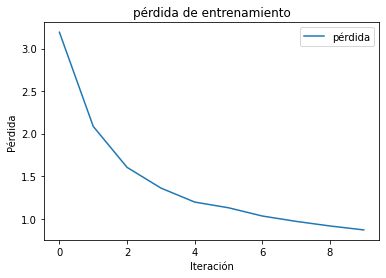

In [ ]:
#se grafica la progresion de la presicion y la perdida
plt.plot(history.history['loss'], label="pérdida")
plt.plot(history.history['val_loss'], label="pérdida de validación")
plt.title('pérdida de entrenamiento y validación')
plt.xlabel('Iteración')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label="pérdida")
plt.title('pérdida de entrenamiento')
plt.xlabel('Iteración')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

#4: Densa


##3 capas ocultas, 30 iteraciones


In [ ]:
model = tf.keras.models.Sequential([ 

    Flatten(input_shape =(HEIGHT, WIDTH, 1)),  #la entrada se declara con la cantidad de neuronas de acuerdo al arreglo de entrada
    Dense(64, activation = 'relu'),
    Dense(128, activation = 'relu'),

    Dense(64, activation = 'relu'),

    tf.keras.layers.Dense(clases, activation="softmax")
])

model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_18 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_86 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_87 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_88 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_89 (Dense)             (None, 47)                3055      
Total params: 69,871
Trainable params: 69,871
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(train_x, train_y, epochs=30, verbose=1, 
                    validation_data=(test_x, test_y))
# model.evaluate(test_x,  test_y, verbose=2)

Epoch 1/30
92/92 [==============================] - 1s 5ms/step - loss: 3.7163 - accuracy: 0.0767 - val_loss: 2.6800 - val_accuracy: 0.2858
Epoch 2/30
92/92 [==============================] - 0s 4ms/step - loss: 2.2652 - accuracy: 0.3884 - val_loss: 2.0127 - val_accuracy: 0.4518
Epoch 3/30
92/92 [==============================] - 0s 4ms/step - loss: 1.6524 - accuracy: 0.5301 - val_loss: 1.7081 - val_accuracy: 0.5301
Epoch 4/30
92/92 [==============================] - 0s 4ms/step - loss: 1.3366 - accuracy: 0.6153 - val_loss: 1.6154 - val_accuracy: 0.5319
Epoch 5/30
92/92 [==============================] - 0s 4ms/step - loss: 1.1639 - accuracy: 0.6600 - val_loss: 1.4921 - val_accuracy: 0.5759
Epoch 6/30
92/92 [==============================] - 0s 4ms/step - loss: 1.0024 - accuracy: 0.6983 - val_loss: 1.4773 - val_accuracy: 0.5911
Epoch 7/30
92/92 [==============================] - 0s 4ms/step - loss: 0.9386 - accuracy: 0.7054 - val_loss: 1.4511 - val_accuracy: 0.5929
Epoch 8/30
92/92 [==

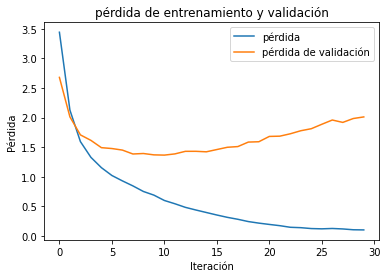

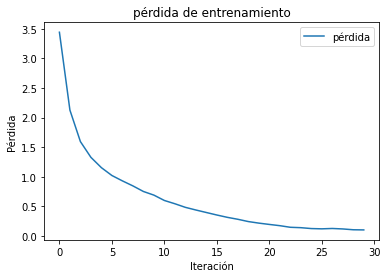

In [ ]:
#se grafica la progresion de la presicion y la perdida
plt.plot(history.history['loss'], label="pérdida")
plt.plot(history.history['val_loss'], label="pérdida de validación")
plt.title('pérdida de entrenamiento y validación')
plt.xlabel('Iteración')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label="pérdida")
plt.title('pérdida de entrenamiento')
plt.xlabel('Iteración')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

##5 capas ocultas, 30 iteraciones

In [ ]:
model = tf.keras.models.Sequential([ 

    Flatten(input_shape =(HEIGHT, WIDTH, 1)),  #la entrada se declara con la cantidad de neuronas de acuerdo al arreglo de entrada
    Dense(64, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(clases, activation="softmax")
])

model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_15 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_73 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_74 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_75 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_76 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_77 (Dense)             (None, 47)              

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(train_x, train_y, epochs=30, verbose=1, 
                    validation_data=(test_x, test_y))
# model.evaluate(test_x,  test_y, verbose=2)

Epoch 1/30
92/92 [==============================] - 1s 7ms/step - loss: 3.7350 - accuracy: 0.0481 - val_loss: 2.9168 - val_accuracy: 0.1918
Epoch 2/30
92/92 [==============================] - 0s 5ms/step - loss: 2.5357 - accuracy: 0.2921 - val_loss: 2.1167 - val_accuracy: 0.3986
Epoch 3/30
92/92 [==============================] - 1s 5ms/step - loss: 1.7465 - accuracy: 0.4768 - val_loss: 1.8311 - val_accuracy: 0.4940
Epoch 4/30
92/92 [==============================] - 0s 5ms/step - loss: 1.3973 - accuracy: 0.5750 - val_loss: 1.5971 - val_accuracy: 0.5486
Epoch 5/30
92/92 [==============================] - 0s 5ms/step - loss: 1.1566 - accuracy: 0.6572 - val_loss: 1.5126 - val_accuracy: 0.5837
Epoch 6/30
92/92 [==============================] - 0s 5ms/step - loss: 0.9126 - accuracy: 0.7166 - val_loss: 1.5072 - val_accuracy: 0.5844
Epoch 7/30
92/92 [==============================] - 0s 5ms/step - loss: 0.7528 - accuracy: 0.7629 - val_loss: 1.3924 - val_accuracy: 0.6004
Epoch 8/30
92/92 [==

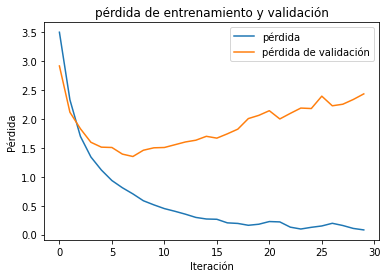

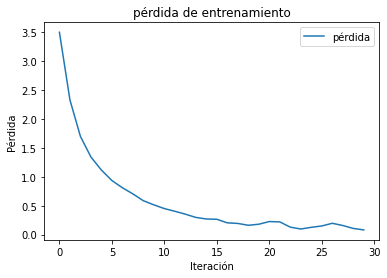

In [ ]:
#se grafica la progresion de la presicion y la perdida
plt.plot(history.history['loss'], label="pérdida")
plt.plot(history.history['val_loss'], label="pérdida de validación")
plt.title('pérdida de entrenamiento y validación')
plt.xlabel('Iteración')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label="pérdida")
plt.title('pérdida de entrenamiento')
plt.xlabel('Iteración')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

#Test with chinese characters

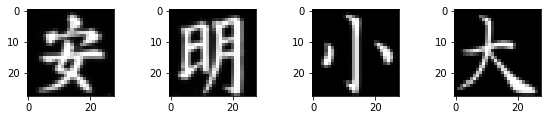

(4, 28, 28, 24)


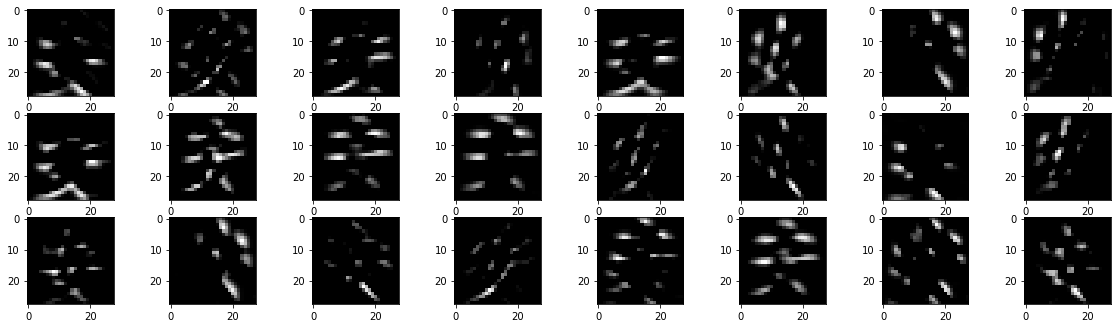

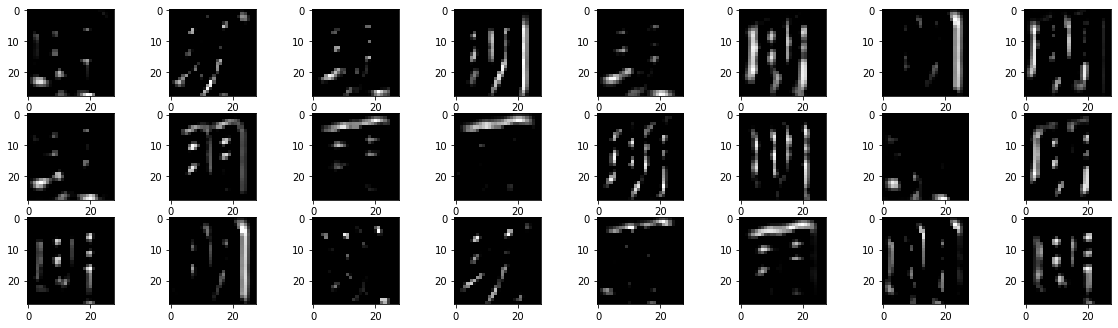

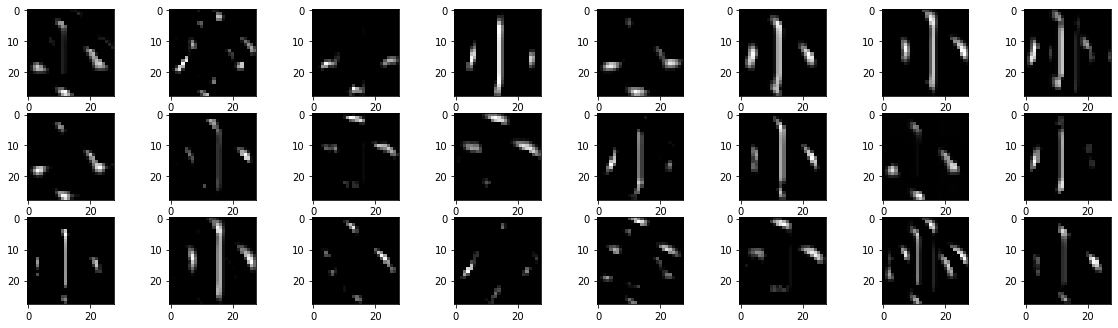

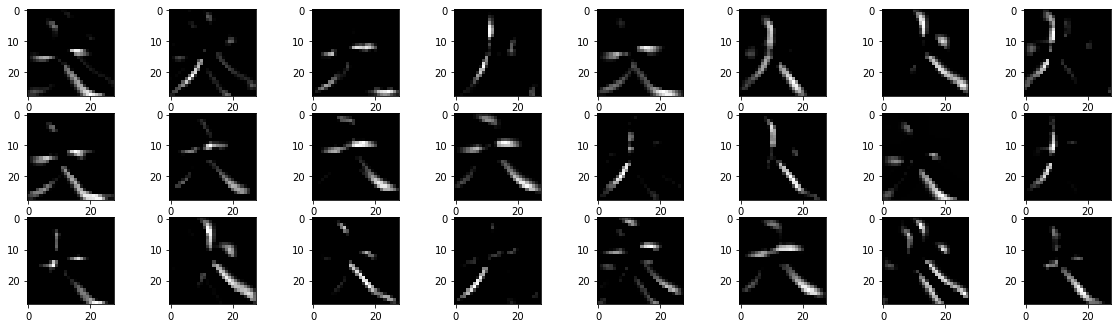

In [ ]:
#cargar las imagenes
imagenes = []
plt.figure(figsize=(20,15))

for i in range(4):
  img = Image.open(f'/content/drive/My Drive/IA_TEC/tarea3/seccion_c/{i+1}.jpg').convert('L')
  img = PIL.ImageOps.invert(img)
  img = np.array(img)

  imagenes.append(img / 255)
  plt.subplot(8,8,i+1)    
  plt.imshow(img, cmap=plt.get_cmap('gray'))

imagenes = np.asarray(imagenes)
# imagenes = imagenes / 255
plt.show()

model_1 = Model(inputs=model.inputs , outputs=model.layers[0].output)

features = model_1.predict(imagenes)

print(f'{np.array(features).shape}')

for letra in range(len(imagenes)):

  fig = plt.figure(figsize=(20,15))

  for i in range(1,features.shape[3]+1):

      plt.subplot(8,8,i)
      plt.imshow(features[letra,:,:,i-1] , cmap='gray')
      
  plt.show()